In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
import numpy as np
import pylab as plt
import swyft

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # replace with 'cpu' if no GPU is available
Ntrain = 3000
Npars = 2

In [4]:
def model(v, sigma = 0.2):
    x = v + np.random.randn(Npars)*sigma
    return dict(x=x)

In [5]:
simulator = swyft.Simulator(model, Npars, sim_shapes = {"x": (Npars,)})
store = swyft.MemoryStore(simulator)

Creating new store.


In [6]:
prior = swyft.Prior(lambda u: u*2-1, Npars)
store.add(Ntrain, prior)
store.simulate()

Store: Adding 2981 new samples to simulator store.


In [7]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)

In [8]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20)

Training: lr=0.001, Epoch=14, VL=0.4268


In [9]:
v0 = np.zeros(Npars)
obs0 = model(v0, sigma = 0.)

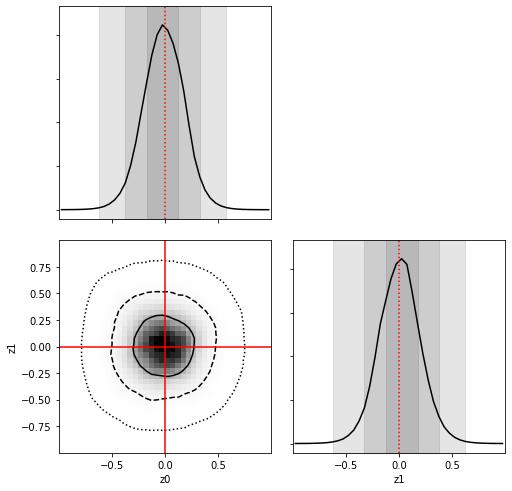

In [10]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);